# multinomial logistic regression

We'll use the mnist dataset

In [1]:
import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_size = 28
space = 2

In [3]:
def plot_tiles(ax, data_img, no_rows, no_cols, img_size=28 , space=2):
    
    image = np.empty(shape=(no_rows * (img_size+space) - space, no_cols * (img_size+2) - space))
    image.fill(np.nan)

    for i in range(no_rows):
        for j in range(no_cols):
            x, y = j*(img_size+space), i*(img_size+space)
            min_v, max_v = np.min(data_img[i,j]), np.max(data_img[i,j])
            image[y:y+img_size,x:x+img_size] = (data_img[i,j]-min_v)/(max_v-min_v)

    ax.matshow(image, cmap='gray', interpolation='none')
    ax.axis('off')

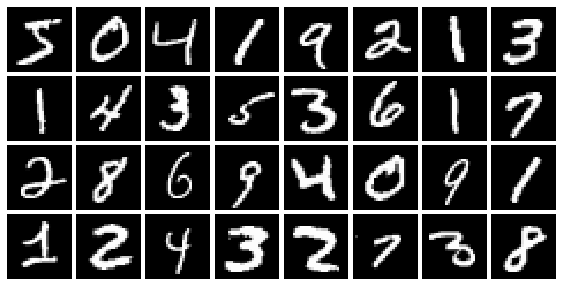

In [4]:
fig = plt.figure(figsize=(10, 5))
plot_tiles(plt.gca(), np.reshape(mnist.train_images()[:4*8], newshape=(4, 8, img_size, img_size)), 4, 8)
plt.show()

## data preparation

Let's prepare the training set ...

In [5]:
train_images = mnist.train_images().astype(np.float32) / 255.0
train_labels = mnist.train_labels()

order = np.random.permutation(len(train_images))

train_images = train_images[order]
train_labels = train_labels[order]

#we'll transform the images int one dimensional vectors
train_images = np.reshape(train_images,newshape=(-1, img_size**2))

ones = np.ones((train_images.shape[0], 1))
train_images = np.concatenate((train_images, ones), axis=1)

one_hot = np.zeros(shape = (train_labels.shape[0], np.max(train_labels) + 1))
one_hot[np.arange(train_labels.shape[0]), train_labels] = 1

train_labels = one_hot.astype(np.float32)

... and testing set

In [6]:
test_images = mnist.test_images().astype(np.float32) / 255.0
test_labels = mnist.test_labels()

test_images = np.reshape(test_images, newshape=(-1, img_size**2))

t_ones = np.ones((test_images.shape[0], 1))
test_images = np.concatenate((test_images, t_ones), axis=1)

t_one_hot = np.zeros(shape = (test_labels.shape[0], np.max(test_labels) + 1))
t_one_hot[np.arange(test_labels.shape[0]), test_labels] = 1

test_labels = t_one_hot.astype(np.float32)

To use logistic regression we'll need a link function. In this case(of multinomial logistic regression) it will be a softmax function:

$\pi_{ij} = \dfrac{e^{z_{ij}}}{\Sigma_{l=1}^k e^{z_{il}}}$

The function will take z as classification logits(certain combinations of model parameters and explanatory variables)

High value of the function for certain j means greater probability of classifying the data to this j's class

In [7]:
def softmax(Z):
    Zmax = np.max(Z,axis=1,keepdims=True) # without this variable we can get overflow problems for big values of Z
    return np.exp(Z-Zmax)/np.sum(np.exp(Z-Zmax),axis=1,keepdims = True)

We'll need a certain cost function and it's gradient function.

We'll have to follow the gradient function to train our model

We'll use cross entropy function

In [8]:
# S is categorical probability distribution(output of softmax function) for certain observations
# T is the vector of encoded labels for the same observations
# we'll try to locally minimize the output value of this function by following the gradient
def xentropy(S, T):
    R = T*np.log(S)
    return -1*np.sum(R)/np.size(S,axis = 0) 

# X is vector of explanatory variables for certain observations
# S and T as in xentropy function above for the observations reffered in the line above
# the function returns average(per input observation) gradient value of xentropy function
def grad_xentropy(X, S, T):
    R = X.T@(S-T)
    return R/np.size(S, axis = 0)

Now we'll also need 2 functions. One that will classify our data after the model is trained and the other one that will calculate the accuracy of our predictions

In [9]:
# W is a vector of model parameters
# X is a 
def classify(W, X):
    # logit vector
    Z = X@W
    
    # softmax value(probability of belonging to each category)
    S = softmax(Z)
    
    predictions = (S==np.max(S,axis = 1, keepdims = True))
    return predictions.astype(int)

In [10]:
# P is a vector of our predicted labels
# T is a vector of true labels
def accuracy(P, T):
    acc = np.sum(P*T) / P.shape[0]
    return 100.0 * acc

Now let's create a function the training function

In [11]:
# W0 is an array with initial parameter values, shape
# X is an containing train data
# T is an array of true class labels for X
# test_X is test data
# test_T is an array of labels for test data
# l2 is regularization hyper parameter
# lr is lerning rate hyper pareameter
# n_steps is number of gradient steps to perform
# progress check is number of steps between each progress check

def fit(W0, X, T, test_X, test_T, l2=0.005, lr=1.0, n_steps=100, progress_check=5):
    W = np.copy(W0)
    
    for step in range(n_steps):
        
        S = softmax(X@W)
        
        W -= lr*(grad_xentropy(X, S, T) + l2*W)
        
        
        
        P = classify(W, X)
        train_acc = accuracy(P, T)
        
        test_P = classify(W, test_X)
        test_acc = accuracy(test_P, test_T)
        
        if step == 0 or (step + 1) % progress_check == 0:
            log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t validation accuracy: {:5.2f}'
            log = log.format(step, xentropy(S,T).item(), train_acc.item(), test_acc.item())
            print(log)
    
    return W

In [12]:
W0 = np.random.randn(img_size**2 + 1, 10)

result_W = fit(W0,train_images,train_labels,test_images,test_labels,l2=0.005, lr=3.0,
                   n_steps=200, progress_check=10)

Step   0	cost value: 13.71,	train accuracy: 22.48,	 validation accuracy: 22.80
Step   9	cost value:  3.20,	train accuracy: 61.09,	 validation accuracy: 61.84
Step  19	cost value:  1.51,	train accuracy: 70.08,	 validation accuracy: 70.13
Step  29	cost value:  1.70,	train accuracy: 73.07,	 validation accuracy: 73.18
Step  39	cost value:  1.47,	train accuracy: 74.64,	 validation accuracy: 74.88
Step  49	cost value:  1.30,	train accuracy: 75.20,	 validation accuracy: 75.53
Step  59	cost value:  1.53,	train accuracy: 74.07,	 validation accuracy: 74.25
Step  69	cost value:  1.15,	train accuracy: 75.87,	 validation accuracy: 76.43
Step  79	cost value:  1.32,	train accuracy: 71.50,	 validation accuracy: 71.60
Step  89	cost value:  0.93,	train accuracy: 74.44,	 validation accuracy: 74.74
Step  99	cost value:  0.70,	train accuracy: 80.35,	 validation accuracy: 80.77
Step 109	cost value:  1.30,	train accuracy: 70.18,	 validation accuracy: 70.31
Step 119	cost value:  0.65,	train accuracy: 81.10,	 

We should change our hyperparameters to achieve beter results

In [13]:
result_W_2 = fit(result_W,train_images,train_labels,test_images,test_labels,l2=0.005, lr=0.3,
                   n_steps=300, progress_check=25)

Step   0	cost value:  2.56,	train accuracy: 79.24,	 validation accuracy: 79.47
Step  24	cost value:  0.40,	train accuracy: 89.38,	 validation accuracy: 90.34
Step  49	cost value:  0.37,	train accuracy: 89.77,	 validation accuracy: 90.65
Step  74	cost value:  0.36,	train accuracy: 90.03,	 validation accuracy: 90.87
Step  99	cost value:  0.35,	train accuracy: 90.18,	 validation accuracy: 91.04
Step 124	cost value:  0.34,	train accuracy: 90.36,	 validation accuracy: 91.15
Step 149	cost value:  0.33,	train accuracy: 90.49,	 validation accuracy: 91.29
Step 174	cost value:  0.33,	train accuracy: 90.61,	 validation accuracy: 91.34
Step 199	cost value:  0.33,	train accuracy: 90.77,	 validation accuracy: 91.42
Step 224	cost value:  0.33,	train accuracy: 90.87,	 validation accuracy: 91.41
Step 249	cost value:  0.33,	train accuracy: 90.95,	 validation accuracy: 91.45
Step 274	cost value:  0.33,	train accuracy: 91.00,	 validation accuracy: 91.52
Step 299	cost value:  0.33,	train accuracy: 91.04,	 

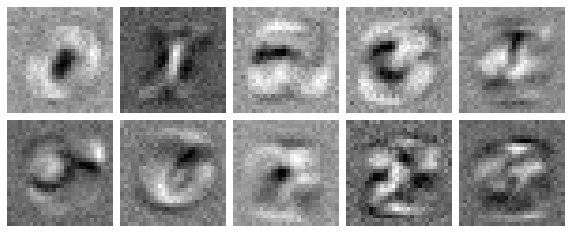

In [14]:
fig = plt.figure(figsize=(10, 5))
plot_tiles(plt.gca(), np.reshape(result_W_2[:-1, :].T, newshape=(2, 5, 28, 28)), 2, 5)
plt.show()